# CNNs and transfer learning

## Introduction

In the past lab we have used the high-level API of PyTorch to implement an MLP. We have seen how shifted images produced significantly worse results, while to the human eye the examples are equally recognisable.

In this lab we will use convolutional layers to increase translation invariance of images. We will start with implementing a convolutional model to perform classification on MNIST and then we will load a pretrained model and use transfer learning on a new dataset of fish images.


## Objectives
- Learn to create a simple CNN model in PyTorch
- Use torch cuda device to improve training performance
- Understand and perform transfer learning using pretrained models


## Evaluation considerations
- We take into account the correctness of the solutions but also their generality and quality of the code
- Comment and discuss on the results of all your exercises (in a cell immediately after the results). You may also state the difficulties encountered, lessons learned and your understanding of the problem and solution
- Clean-up your code before submission, do not leave unnecessary code attempts, or if you deem it important, leave them in a way that it is easily understood and with comments/discussion
- We also value the originality of the solutions, don't hesitate in performing unrequested additional tasks in relation to the exercises specially for the advanced exercises.

## Getting started

We will first import all necessary modules:

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


import numpy as np
import matplotlib.pyplot as plt

## Convolutional neural network

In order to build a CNN we use Convolutional layers from PyTorch. In the case of images we will need 2D convolutions.


## Exercise 1

Implement the following model using PyTorch:

```
- convolutional 1 input channel (grayscale images), 6 output channels, kernel 5x5, stride 1x1
- rectified linear unit
- max pooling 2x2
- convolutional 6 input channels, 16 output channels, kernel 5x5, stride 1x1
- rectified linear unit
- max pooling 2x2
- flatten
- linear 120 output units
- rectified linear unit
- linear 84 output units
- rectified linear unit
- linear 10 output units
```

**Note:** we must provide the input dimension of the first linear layer. This will depend on how the convolutional and pooling layers have downsampled the input images. By carefully looking at the docs of PyTorch we can compute the output dimensions before the linear layer. The lazy way is:
- put an arbitrary value
- print the shape of `x` after every operation
- run a forward on a single batch (you may obtain a single batch from a dataloader with `next(iter(my_dataloader))`
- check where it fails and correct the input dimension of that layer  

For now you may simply put your best guess and we will correct it after running the next cell.

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    ### BEGIN SOLUTION
    self.net = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels= 6, kernel_size=5, stride =1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size =2),
        nn.Conv2d(6,16,5),
        nn.ReLU(),
        nn.MaxPool2d(2),
        #Flatten(1)
        nn.Flatten(),
        nn.Linear(256, 120),
        nn.ReLU(),
        nn.Linear(120,84),
        nn.ReLU(),
        nn.Linear(84,10)
    )



  def forward(self,x):
      return self.net(x)
### END SOLUTION

model = Net()
print(model)

x = torch.randn((1,1,28,28))
model(x).size()

Net(
  (net): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=256, out_features=120, bias=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU()
    (11): Linear(in_features=84, out_features=10, bias=True)
  )
)


torch.Size([1, 10])

## Exercise 2
Create the datasets and data loaders for the MNIST dataset as done in the previous lab. Take the first batch and run a forward of the model correcting the input dimension of the first `Linear` layer.

100%|██████████| 9912422/9912422 [00:00<00:00, 117638585.49it/s]

Extracting data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to data/mnist/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 27777045.13it/s]


Extracting data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 30210161.35it/s]


Extracting data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 23432384.71it/s]


Extracting data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist/MNIST/raw

tensor([[-0.1453,  0.0214,  0.1321,  0.0606,  0.0928, -0.0301, -0.1075, -0.0243,
          0.0281,  0.0076]], grad_fn=<AddmmBackward0>)


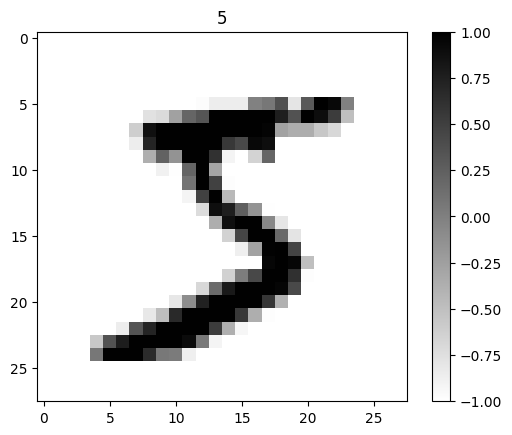

In [ ]:
### BEGIN SOLUTION
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

train_set =torchvision.datasets.MNIST(
    root="data/mnist",# laocation of MNIST Origin folder
    train=True,       # creating a dataset for the training set
    download=True,
    transform=transform   # transforming the data before usage.
)
test_set = torchvision.datasets.MNIST(
    root="data/mnist",
    train=False,
    download=True,
    transform=transform

)

inputs, y = train_set[0]


### END SOLUTION

output = model(inputs.reshape(1,1,28,28))
print(output)

# plotting first image just to check that it is working
plt.imshow(inputs[0], cmap = 'gray_r')
plt.colorbar()
plt.title(y)
plt.show()

## Exercise 3

Train the model as done in the previous lab. Given that epochs take longer to compute with these models, we will print the average loss value every 1000 iterations. Write the train function so that every 1000 iterations it prints the average loss over these past 1000 iterations.

**Note:** We will measure how long it takes to run this cell by adding the *cell magic* command `%%time`

In [ ]:
def train_model(model, dataloader, optimizer, criterion, n_epochs=1):
    model.train()

    for epoch in range(n_epochs):
        running_loss = 0.
        running_examples = 0
        for iter, batch in enumerate(dataloader):
            ### BEGIN SOLUTION

            inputs, labels = batch

            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs,labels)

            loss.backward()

            running_loss += loss.item()

            running_examples += inputs.shape[0]

            if iter % 1000 == 999:
                print(f'ep:{epoch: 3d}, iteraion: {iter: 5d}, loss: {running_loss/running_examples:.3f}')
                running_loss  = 0
                running_examples = 0

            optimizer.step()
            ### END SOLUTION


def evaluate_model(model, dataloader):
    model.eval()

    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in dataloader:
                  ## BEGIN SOLUTION
            images, labels = data
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            ## END SOLUTION

    accuracy = correct/total
    return accuracy


model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

batch_size = 16

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

train_model(model, train_loader, optimizer, criterion, n_epochs=2)
accuracy = evaluate_model(model, test_loader)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')


ep:  0, iteraion:   999, loss: 0.121
ep:  0, iteraion:  1999, loss: 0.025
ep:  0, iteraion:  2999, loss: 0.014
ep:  1, iteraion:   999, loss: 0.008
ep:  1, iteraion:  1999, loss: 0.007
ep:  1, iteraion:  2999, loss: 0.006
Accuracy of the network on the test images: 97.2%


We notice that the change in architecture improves the accuracy obtained on the test set. However we also notice the training and testing takes longer. Convolutions are operations that can benefit significantly from GPU processing.

We will now learn how to move the data and operations to the GPU device to take advantage of its benefits.

The first thing to do is to obtain the GPU `device` if available, falling back to the CPU if the GPU is not available. This can be done with the following statement:

```
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
```

Then we may move the `nn.Module` that we want run in GPU:

```
model.to(device)
```

We must also move the data `inputs` and `labels` to the GPU before using them.

```
inputs, labels = inputs.to(device), labels.to(device)
```

**Note:** in Google's Collaboratory environment we may request running the Python kernel on a GPU. To do so go to the Menu > Runtime > Change runtime type. Only use this feature when needed to avoid using unnecessary ressources.

## Exercise 4

Re-train the model, this time on GPU. While we are at it, make the frequency of logging parametrizable (i.e. using the value of the keyword argument `log_every` as the period of logs).

In [ ]:
%%time

def train_model(model, dataloader, optimizer, criterion, n_epochs=1, log_every=100, device='cpu'):
    ### BEGIN SOLUTION
    model.to(device)
    model.train()

    for epoch in range(n_epochs):
      running_loss =0
      running_examples = 0
      for iter, batch in enumerate(dataloader):

        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        running_loss += loss.item()
        running_examples += inputs.shape[0]

        if iter % log_every ==0:
          print(f'ep: {epoch: 3d}, iteration: {iter: 5d}, loss is : {running_loss/running_examples:.3f}')
          running_loss = 0
          running_examples = 0
        optimizer.step()

def evaluate_model(model, dataloader, device = 'cpu'):

  model.to(device)
  model.eval()

  correct = 0
  total = 0

  with torch.no_grad():
    for data in dataloader:

      inputs, labels =data
      inputs, labels = inputs.to(device), labels.to(device)


      outputs = model(inputs)


      _, pred = torch.max(outputs.data,1)
      total += labels.size(0)
      correct += (pred ==labels).sum().item()


  accuracy =correct /total
  return accuracy




    ### END SOLUTION

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

batch_size = 16

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=2)

train_model(model, train_loader, optimizer, criterion, n_epochs=2, device=device)
accuracy = evaluate_model(model, test_loader, device=device)
print(f'Accuracy of the network on the 10000 test images: {accuracy:.1%}')


ep:   0, iteration:     0, loss is : 0.143
ep:   0, iteration:   100, loss is : 0.144
ep:   0, iteration:   200, loss is : 0.144
ep:   0, iteration:   300, loss is : 0.143
ep:   0, iteration:   400, loss is : 0.142
ep:   0, iteration:   500, loss is : 0.141
ep:   0, iteration:   600, loss is : 0.137
ep:   0, iteration:   700, loss is : 0.123
ep:   0, iteration:   800, loss is : 0.084
ep:   0, iteration:   900, loss is : 0.054
ep:   0, iteration:  1000, loss is : 0.040
ep:   0, iteration:  1100, loss is : 0.033
ep:   0, iteration:  1200, loss is : 0.026
ep:   0, iteration:  1300, loss is : 0.023
ep:   0, iteration:  1400, loss is : 0.020
ep:   0, iteration:  1500, loss is : 0.020
ep:   0, iteration:  1600, loss is : 0.020
ep:   0, iteration:  1700, loss is : 0.019
ep:   0, iteration:  1800, loss is : 0.016
ep:   0, iteration:  1900, loss is : 0.016
ep:   0, iteration:  2000, loss is : 0.020
ep:   0, iteration:  2100, loss is : 0.014
ep:   0, iteration:  2200, loss is : 0.013
ep:   0, it

In this case the speed-up may not be too noticeable because the model is small. But we can now increase the number of convolutional filters without having a large impact on training time.

## Exercise 5

Try changing the number of filters of the first convolution to 16 and the next to 36.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        ### BEGIN SOLUTION
        super().__init__()
        self.net = nn.Sequential(
            # The number of filters in a Convolutional layer are the
            # output channels, so for this excercise we only need to change
            # those values.
            nn.Conv2d(in_channels=1,  out_channels=16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2),
            # The number of filters determine the depth of the output layer.
            # Higher the number of filters, higher is the possibility to learn
            # From complex data, but can result in an overfitting.
            nn.Conv2d(16, 32, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        return self.net(x)

        ### END SOLUTION

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

CNN_losses  = train_model(model, train_loader, optimizer, criterion, n_epochs=2, device=device)
accuracy = evaluate_model(model, test_loader, device=device)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')

ep:   0, iteration:     0, loss is : 0.145
ep:   0, iteration:   100, loss is : 0.144
ep:   0, iteration:   200, loss is : 0.142
ep:   0, iteration:   300, loss is : 0.140
ep:   0, iteration:   400, loss is : 0.134
ep:   0, iteration:   500, loss is : 0.115
ep:   0, iteration:   600, loss is : 0.072
ep:   0, iteration:   700, loss is : 0.039
ep:   0, iteration:   800, loss is : 0.033
ep:   0, iteration:   900, loss is : 0.030
ep:   0, iteration:  1000, loss is : 0.026
ep:   0, iteration:  1100, loss is : 0.022
ep:   0, iteration:  1200, loss is : 0.018
ep:   0, iteration:  1300, loss is : 0.017
ep:   0, iteration:  1400, loss is : 0.015
ep:   0, iteration:  1500, loss is : 0.015
ep:   0, iteration:  1600, loss is : 0.015
ep:   0, iteration:  1700, loss is : 0.014
ep:   0, iteration:  1800, loss is : 0.012
ep:   0, iteration:  1900, loss is : 0.012
ep:   0, iteration:  2000, loss is : 0.015
ep:   0, iteration:  2100, loss is : 0.010
ep:   0, iteration:  2200, loss is : 0.010
ep:   0, it

We will now test whether using CNN allows us to improve performance on the test set of shifted images.

## Exercise 6
Create a new `test_shifted_set` and `test_shifted_loader` where images are shifted 3 pixels to the right and plot the first image. Use the transforms API of PyTorch (e.g. `transforms.Lambda`).

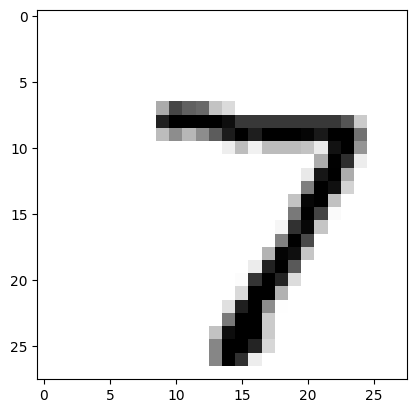

In [ ]:
transform = transforms.Compose(
    [
        ### BEGIN SOLUTION
      # convertthe inputs from PIL into tensor
        transforms.ToTensor(),

        transforms.Lambda(lambda x: torch.roll(x,shifts =3)),

        transforms.Normalize((0.5,),(0.5,))

        ### END SOLUTION
     ])

test_shifted_set = torchvision.datasets.MNIST('data/mnist', download=True, train=False, transform=transform)

test_shifted_loader = torch.utils.data.DataLoader(test_shifted_set, batch_size=batch_size)

plt.imshow(test_shifted_set[0][0][0], cmap='gray_r')
plt.show()

## Exercise 7

Test the performance of the previously trained model on the new test set.

In [ ]:
### BEGIN SOLUTION
test_shifted_set[0][0][0].size()

# verifies if there is a GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
accuracy = evaluate_model(model, test_shifted_loader, device = device)

### END SOLUTION

print(f'Accuracy of the network on the test images: {accuracy:.1%}')

Accuracy of the network on the test images: 84.6%


## [Advanced] Exercise 8

Compare the performance of an MLP vs CNN for shifts of increasing number of pixels.

In [ ]:
class mlp(nn.Module):
    def __init__(self):
        super().__init__()
        # Defining the layers, 64 and 10 units each
        self.fc1 = nn.Linear(784, 64)
        self.fc2 = nn.Linear(64, 10)


    def forward(self, x):
        # Flatten the input image
        x = torch.flatten(x,1)
        # Pass through the first fully connected layer
        x = self.fc1(x)
        # Apply sigmoid activation function
        x = torch.sigmoid(x)
        # Pass through the second fully connected layer
        x = self.fc2(x)
        # Apply softmax activation function
        x = F.softmax(x, dim=1)

        return x

model_mlp = mlp()
model_mlp

MLP_losses = train_model(model_mlp, train_loader, optimizer, criterion, n_epochs=2, device=device)
accuracy = evaluate_model(model_mlp, test_shifted_loader, device=device)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')






ep:   0, iteration:     0, loss is : 0.144
ep:   0, iteration:   100, loss is : 0.144
ep:   0, iteration:   200, loss is : 0.144
ep:   0, iteration:   300, loss is : 0.144
ep:   0, iteration:   400, loss is : 0.144
ep:   0, iteration:   500, loss is : 0.144
ep:   0, iteration:   600, loss is : 0.144
ep:   0, iteration:   700, loss is : 0.144
ep:   0, iteration:   800, loss is : 0.144
ep:   0, iteration:   900, loss is : 0.144
ep:   0, iteration:  1000, loss is : 0.144
ep:   0, iteration:  1100, loss is : 0.144
ep:   0, iteration:  1200, loss is : 0.144
ep:   0, iteration:  1300, loss is : 0.144
ep:   0, iteration:  1400, loss is : 0.144
ep:   0, iteration:  1500, loss is : 0.144
ep:   0, iteration:  1600, loss is : 0.144
ep:   0, iteration:  1700, loss is : 0.144
ep:   0, iteration:  1800, loss is : 0.144
ep:   0, iteration:  1900, loss is : 0.144
ep:   0, iteration:  2000, loss is : 0.144
ep:   0, iteration:  2100, loss is : 0.144
ep:   0, iteration:  2200, loss is : 0.144
ep:   0, it

## [Advanced] Exercise 9

Propose a solution (and optionally implement it) to make the models even more robust to shifts?

Your reponse here

In [ ]:
class Net_modified(nn.Module):
  def __init__(self):
    ### Begine Solution
    super().__init__()
    # changing the number of filters of the first convolution
    self.conv1 = nn.Conv2d(1,16,5,stride = 1)
    self.pool1 = nn.MaxPool2d(kernel_size = 3, stride =2 ,padding =0, dilation =1, ceil_mode=False)
    # changing the number of filters of second convolution
    self.conv2 = nn.Conv2d(16,36,kernel_size =(5,5),stride=(1,1))
    self.fc1   = nn.Linear(in_features = 324, out_features = 120, bias = True)
    self.fc2   = nn.Linear(in_features = 120, out_features=84, bias = True)
    self.fc3   = nn.Linear(in_features=84, out_features=10, bias=True)
    self.relu  = nn.ReLU()


  def forward(self,x):
    x =self.conv1(x)
    x =self.relu(x)
    x =self.pool1(x)
    x =self.conv2(x)
    x =self.relu(x)
    x =self.pool1(x)
    x = torch.flatten(x,1)
    x =self.fc1(x)
    x =self.relu(x)
    x =self.fc2(x)
    x =self.relu(x)
    x =self.fc3(x)
    return x
  ### End solution

# take an instance if the Net_modified() class and choose the criterion(cross entropy) and the optimizer (SGD)

model = Net_modified()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr  =0.0001, momentum=0.9)
#train the model
train_model(model,train_loader,optimizer,criterion,n_epochs=2,device=device)
#evaluate the accuracy of the model on the shifted test set
accuracy = evaluate_model(model,test_shifted_loader,device=device)
print(f'Accuracy of the nn on the shifted test images: {accuracy:.1%}')






ep:   0, iteration:     0, loss is : 0.145
ep:   0, iteration:   100, loss is : 0.144
ep:   0, iteration:   200, loss is : 0.144
ep:   0, iteration:   300, loss is : 0.144
ep:   0, iteration:   400, loss is : 0.144
ep:   0, iteration:   500, loss is : 0.144
ep:   0, iteration:   600, loss is : 0.144
ep:   0, iteration:   700, loss is : 0.144
ep:   0, iteration:   800, loss is : 0.144
ep:   0, iteration:   900, loss is : 0.143
ep:   0, iteration:  1000, loss is : 0.143
ep:   0, iteration:  1100, loss is : 0.143
ep:   0, iteration:  1200, loss is : 0.143
ep:   0, iteration:  1300, loss is : 0.143
ep:   0, iteration:  1400, loss is : 0.143
ep:   0, iteration:  1500, loss is : 0.143
ep:   0, iteration:  1600, loss is : 0.143
ep:   0, iteration:  1700, loss is : 0.143
ep:   0, iteration:  1800, loss is : 0.143
ep:   0, iteration:  1900, loss is : 0.143
ep:   0, iteration:  2000, loss is : 0.143
ep:   0, iteration:  2100, loss is : 0.143
ep:   0, iteration:  2200, loss is : 0.142
ep:   0, it

# Transfer learning

It is quite rare that we implement new models from scratch, specially when our target dataset is small.

We will often perform what is known as transfer learning: **start from well-established models pre-trained on large quantities of similar data**. For example, for natural image related tasks we will often start from a `ResNet` or `MobileNet`, whose weights have been trained on a classification task on ImageNet.

The model chosen to base our work on is often referred to as the **backbone**.

Depending on the task the pre-trained model may not be directly usable. Even when performing a classification task, the classes may not be the same, even the number of classes may vary. Therefore, for sure the output layer of the model may need to be modified (and re-trained).

PyTorch provides pre-trained models from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) and from [PyTorch Hub](https://pytorch.org/hub/). Throughout this lab we will use the PyTorch Hub way.

For instance to download a [ResNet-18 model](https://pytorch.org/hub/pytorch_vision_resnet/) we would do:

```
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
```

To practice the methodology of transfer learning, we will use a small dataset provided by [here](https://homepages.inf.ed.ac.uk/rbf/fish4knowledge/GROUNDTRUTH/RECOG/)

We will do the following steps:
1. Download the data and untar it
2. Create a dataset object using [torchvision.datasets.ImageFolder](https://pytorch.org/vision/stable/datasets.html?highlight=imagefolder#torchvision.datasets.ImageFolder)
3. Split the dataset into train and test using [sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
4. Train several models on the data
    1. A simple custom made CNN model
    2. A ResNet-18 without pretrained weights
    3. A ResNet-18 with pretrained weights training only the last layer

When splitting the data into train and test we will do a 80% / 20% ratio per each class (stratified). <!--We notice in the dataset that consecutive images seem to be extracted often from the same video segment, therefore we will split data in consecutive chunks instead of shuffling it (random split).-->


## Exercise 10
Download the data and untar it. Using `wget` (run with the `-nc` flag to avoid redownloading unnecessarily multiple times) and `tar`. Bash commands in Colab and Jupyter must be preceded by a `!`.

In [ ]:
### BEGIN SOLUTION
!wget -nc https://homepages.inf.ed.ac.uk/rbf/fish4knowledge/GROUNDTRUTH/RECOG/Archive/fishRecognition_GT.tar
### END SOLUTION

--2023-11-25 20:02:18--  https://homepages.inf.ed.ac.uk/rbf/fish4knowledge/GROUNDTRUTH/RECOG/Archive/fishRecognition_GT.tar
Resolving homepages.inf.ed.ac.uk (homepages.inf.ed.ac.uk)... 129.215.32.113
Connecting to homepages.inf.ed.ac.uk (homepages.inf.ed.ac.uk)|129.215.32.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 510912000 (487M) [application/x-tar]
Saving to: ‘fishRecognition_GT.tar’

fishRecognition_GT. 100%[===================>] 487.24M  28.5MB/s    in 18s     

2023-11-25 20:02:36 (27.3 MB/s) - ‘fishRecognition_GT.tar’ saved [510912000/510912000]



In [ ]:
!tar xf fishRecognition_GT.tar

tar: A lone zero block at 997875


## Exercise 11
Create a `torchvision.datasets.ImageFolder` for the full fish recognition dataset and plot the first example.

We will not normalise at first, we will do so later.

In [ ]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),

    ]
    )

### BEGIN SOLUTION
full_set = torchvision.datasets.ImageFolder(
    root = "fish_image",
    transform = transform
)
### END SOLUTION

full_set.classes = [
                    'Dascyllus reticulatus',
                    'Plectroglyphidodon dickii',
                    'Chromis chrysura',
                    'Amphiprion clarkii',
                    'Chaetodon lunulatus',
                    'Chaetodon trifascialis',
                    'Myripristis kuntee',
                    'Acanthurus nigrofuscus',
                    'Hemigymnus fasciatus',
                    'Neoniphon sammara',
                    'Abudefduf vaigiensis',
                    'Canthigaster valentini',
                    'Pomacentrus moluccensis',
                    'Zebrasoma scopas',
                    'Hemigymnus melapterus',
                    'Lutjanus fulvus',
                    'Scolopsis bilineata',
                    'Scaridae',
                    'Pempheris vanicolensis',
                    'Zanclus cornutus',
                    'Neoglyphidodon nigroris',
                    'Balistapus undulatus',
                    'Siganus fuscescens'
]

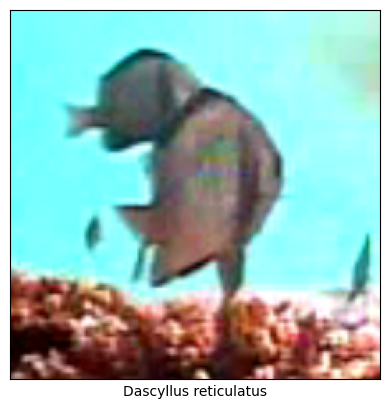

In [ ]:
### BEGIN SOLUTION
image, label  =full_set[0]
#converting the image from tensor to Numpy array

normalize = transforms.Compose([
    transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
])


image = normalize(image)
plt.imshow(image.permute(1,2,0))

### END SOLUTION

plt.xticks([])
plt.yticks([])
plt.xlabel(full_set.classes[label])
plt.show()

In [ ]:
image.shape


torch.Size([3, 224, 224])

## Exercise 12

Compute on a batch of 500 random samples the mean and std deviation for each of the RGB channels.

Then create a new dataset called `full_set` this time using `Normalize` in the transform so as to have whitenned images. We will also set the classes here for later use.

In [ ]:
loader = torch.utils.data.DataLoader(full_set, batch_size=500, shuffle=True, num_workers=1)
# use the interior to get a random batch of 500 samples
data = next(iter(loader))

### BEGIN SOLUTION
# Calculate mean and std of our raw data
mean  = 0
std = 0
# compute the mean along first, second, third dimensions of Tensor.
mean  = torch.mean(data[0], dim=(0,2,3))
# compute the std along the first, second, third dimensions of Tensor.
std  = torch.std(data[0],dim=(0,2,3))

### END SOLUTION

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    ### BEGIN SOLUTION
    # Apply normalisation
    transforms.Normalize(mean=mean,std=std)
    ### END SOLUTION
    ]
    )

full_set = torchvision.datasets.ImageFolder('fish_image', transform=transform)

full_set.classes = [
                    'Dascyllus reticulatus',
                    'Plectroglyphidodon dickii',
                    'Chromis chrysura',
                    'Amphiprion clarkii',
                    'Chaetodon lunulatus',
                    'Chaetodon trifascialis',
                    'Myripristis kuntee',
                    'Acanthurus nigrofuscus',
                    'Hemigymnus fasciatus',
                    'Neoniphon sammara',
                    'Abudefduf vaigiensis',
                    'Canthigaster valentini',
                    'Pomacentrus moluccensis',
                    'Zebrasoma scopas',
                    'Hemigymnus melapterus',
                    'Lutjanus fulvus',
                    'Scolopsis bilineata',
                    'Scaridae',
                    'Pempheris vanicolensis',
                    'Zanclus cornutus',
                    'Neoglyphidodon nigroris',
                    'Balistapus undulatus',
                    'Siganus fuscescens'
]

print(mean)
print(std)

tensor([0.4719, 0.6019, 0.5736])
tensor([0.2534, 0.3142, 0.3179])


## Exercise 13

Using the [`sklearn.model_selection.train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) and the labels from `full_set.targets` perform a stratified random split.

Then create the two new datasets `train_set` and `test_set` using [`torch.utils.data.Subset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Subset)

In [ ]:
from sklearn.model_selection import train_test_split
labels = list(full_set.targets)
indices = np.arange(len(labels))

# Random splits
### BEGIN SOLUTION
from torch.utils.data.dataset import Subset

train_indices, test_indices = train_test_split(indices, test_size =0.2, random_state =42, stratify=labels)

# create the train and test sets
train_set = Subset(full_set,train_indices)
test_set  =Subset(full_set, test_indices)

### END SOLUTION

In [ ]:
print(len(train_set))
print(len(test_set))

21896
5474


## Exercise 14

Before tackling transfer learning with an existing model, we will revisit the simple CNN and training procedure we built for MNIST earlier in this lab and make a few modifications.

1. We must first adapt the input to 3 channels (RGB)
2. Adapt the output of the network to the number of classes in our task
3. Increase the number of convolutional layers to 3 (we have larger images) with number of filters `[6, 16, 32]`
4. Adapt the number of inputs of the first fully connected layer
5. Increase the batch size to `64` to improve training time

In [ ]:
### BEGIN SOLUTION
class Net(nn.Module):
    ### BEGIN SOLUTION
    def __init__(self,n_classes):
      super().__init__()
      self.n_classes  = n_classes
      self.net  =nn.Sequential(

          nn.Conv2d(in_channels = 3, out_channels =6, kernel_size=5, stride=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size =2),

          # the number of filters determine the depth of the output layer.
          # Higher the number of filters, higher is the possibility to learn.
          #from complex data, but can result in overfitting.

          nn.Conv2d(6,16,5),
          nn.ReLU(),
          nn.MaxPool2d(2),
          nn.Conv2d(16,32,5),
          nn.ReLU(),
          nn.MaxPool2d(2),
          nn.Flatten(),
          nn.Linear(18432, 256),
          nn.ReLU(),
          nn.Linear(256,84),
          nn.ReLU(),
          nn.Linear(84,self.n_classes)

      )
    def forward(self,x):
      return self.net(x)

def train_model(model, dataloader, optimizer, criterion, n_epochs=1, log_every=200, device='cpu'):

  # moves the model to current device.
  model.to(device)
  # starts the traingin mode
  model.train()

  for epoch in range(n_epochs):
    running_loss =0
    running_examples = 0
    for iter, batch in enumerate(dataloader):
      # selects the inputs images, and the class.
      inputs, labels =batch
      inputs, labels =inputs.to(device), labels.to(device)

      optimizer.zero_grad()

      outputs = model(inputs)
      loss = criterion(outputs, labels)

      loss.backward()

      running_loss += loss.item()
      running_examples +=inputs.shape[0]

      if iter % log_every ==0:
        print(f'episode: {epoch: 3d}, iter:{iter: 5d}, Loss: {running_loss/running_examples:.3f}')
        running_loss = 0
        running_examples = 0

      optimizer.step()

def evaluate_model(model, dataloader, device='cpu'):
    ### BEGIN SOLUTION
    model.to(device)
    model.eval()

    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in dataloader:
            ## BEGIN SOLUTION
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # calculate outputs by running images through the network
            outputs = model(inputs)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            ## END SOLUTION

    accuracy = correct/total
    return accuracy

### END SOLUTION

batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, pin_memory=True, num_workers=2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Net(len(full_set.classes))
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train_model(model, train_loader, optimizer, criterion, n_epochs=2, device=device, log_every=50)
accuracy = evaluate_model(model, test_loader, device=device)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')

episode:   0, iter:    0, Loss: 0.050
episode:   0, iter:   50, Loss: 0.047
episode:   0, iter:  100, Loss: 0.026
episode:   0, iter:  150, Loss: 0.016
episode:   0, iter:  200, Loss: 0.013
episode:   0, iter:  250, Loss: 0.011
episode:   0, iter:  300, Loss: 0.010
episode:   1, iter:    0, Loss: 0.006
episode:   1, iter:   50, Loss: 0.009
episode:   1, iter:  100, Loss: 0.009
episode:   1, iter:  150, Loss: 0.008
episode:   1, iter:  200, Loss: 0.008
episode:   1, iter:  250, Loss: 0.007
episode:   1, iter:  300, Loss: 0.007
Accuracy of the network on the test images: 87.2%


We will now create two utility function to help us visualize the outputs of an image classification model.

## Exercise 15

Create a function that takes an image, a model and list of classes and plots the image and a horizontal bar plot (using [`plt.barh`](https://matplotlib.org/stable/gallery/lines_bars_and_markers/barh.html)) showing the probabilities assigned to the top 10 predicted classes (using [`torch.topk`](https://pytorch.org/docs/stable/generated/torch.topk.html?highlight=topk#torch.topk)). Test it on the first image of the test set and using previous trained model.

**Note**: think of bringing back to the cpu and converting to numpy `my_np_array = my_torch_tensor.cpu().numpy()` torch tensors that are in the GPU.

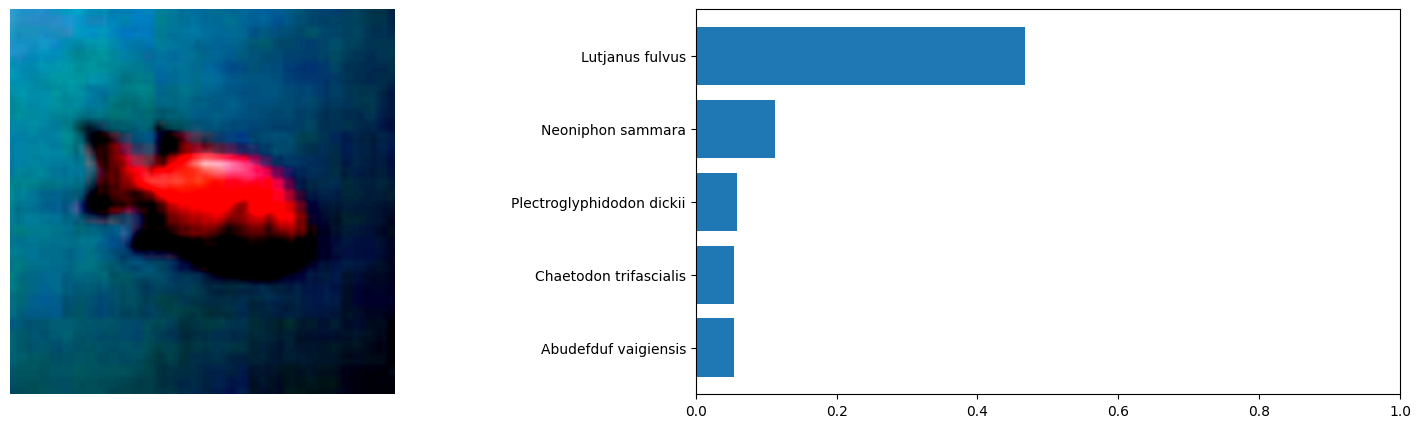

<Figure size 640x480 with 0 Axes>

In [ ]:
def viz_image(image, model, classes, top=5, device='cpu'):
    assert image.ndim == 3, "Images are expected to have 3 dimensions: channels x height x width"
    # Save the initial training mode of the model
    was_training = model.training
    # Set the model to evaluation mode
    model.eval()

    with torch.no_grad():
        ### BEGIN SOLUTION
        image  =image.permute(2,1,0)

        image_2  =np.rot90(image)

        image = image.to(device)
        model = model.to(device)

        image = image.to(device)
        model  =model.to(device)
         # Unsqueeze the image to add a batch dimension and permute dimensions for model input
        image = image.unsqueeze(0)
        image = image.permute(0,3,1,2)

        output  = model(image)

        probs, preds =torch.topk(torch.softmax(output,dim=1),k=top)
        probs, preds =probs.cpu().numpy(), preds.cpu().numpy()


    fig, axs  = plt.subplots(1,2,figsize=(20,5))
    # Display the input image
    axs[0].imshow(image_2)
    axs[0].axis('off')
    axs[0].invert_yaxis() # to invert the image axis so Matplotlib (the top-left), while PyTorch (the bottom-left).

# Create a horizontal bar plot for class probabilities
    axs[1].invert_yaxis()
    axs[1].barh(np.arange(top), probs[0], align ='center')
    axs[1].set_yticks(np.arange(top))
    axs[1].set_yticklabels([classes[pred] for pred in preds[0]])
    axs[1].set_xlim(0,1)

    plt.show()

        ### END SOLUTION

    plt.tight_layout()
    model.train(was_training)

#device  ='cpu'
image, label = test_set[0]
viz_image(image, model, full_set.classes, device=device)

## Exercise 16

Next we will visualize a batch of images and the class predicted by the model with it's probability in parentheses as their `xlabel`.
The function will also return the probabilites of all classes predicted for each image (tensor of `torch.float` with shape `(N, 1000)` where `N` is the number of images in the batch) and the class predicted by the model for each image (tensor of `torch.long` with shape `(N)`).

**Hint**: for create a grid of images consider the following snippet

```
fig = plt.figure(figsize=(10, 10))
for i, image in enumerate(images):
    ax = fig.add_subplot(n_rows, n_cols, i+1)

    # some code to normalize each image

    ax.imshow(...
```

**Note**: Normalize the pixels of each image between 0 and 1 before plotting it to obtain natural colors. Remember we need to do this, because each image was previously normalized to mean 0 and stddev 1 in order to be fed in the expected way by the model.

(tensor([[3.8514e-04, 1.0304e-01, 1.5908e-04, 3.8328e-05, 2.9477e-04, 8.0405e-05,
          8.8370e-01, 9.0091e-05, 2.0801e-03, 1.6228e-03, 3.5329e-04, 2.0897e-04,
          1.6297e-04, 6.4528e-05, 9.7245e-05, 6.3255e-03, 2.5578e-05, 2.6394e-04,
          1.0500e-04, 1.7587e-04, 6.1855e-05, 2.4053e-04, 4.2881e-04],
         [9.4595e-02, 2.1956e-03, 9.0242e-01, 1.8150e-05, 5.7327e-09, 7.3728e-06,
          2.3657e-06, 1.3465e-04, 1.0723e-04, 3.8143e-06, 1.5585e-06, 2.3660e-06,
          3.9194e-08, 3.7525e-04, 1.4128e-05, 1.6231e-07, 6.1198e-06, 6.9207e-05,
          3.1272e-05, 5.4010e-07, 1.4507e-05, 7.7445e-07, 3.3478e-06],
         [9.9925e-01, 2.5367e-04, 2.9496e-04, 9.3110e-05, 3.3762e-08, 8.2669e-06,
          3.1030e-08, 6.4187e-06, 2.1905e-06, 1.2059e-09, 5.4722e-06, 6.4615e-05,
          1.4268e-06, 3.3633e-07, 5.6430e-06, 9.6896e-09, 2.0836e-06, 3.9584e-07,
          3.1040e-07, 1.7214e-07, 4.3862e-06, 1.0801e-05, 4.5376e-07],
         [7.2245e-01, 6.6682e-02, 5.5034e-04, 4.0

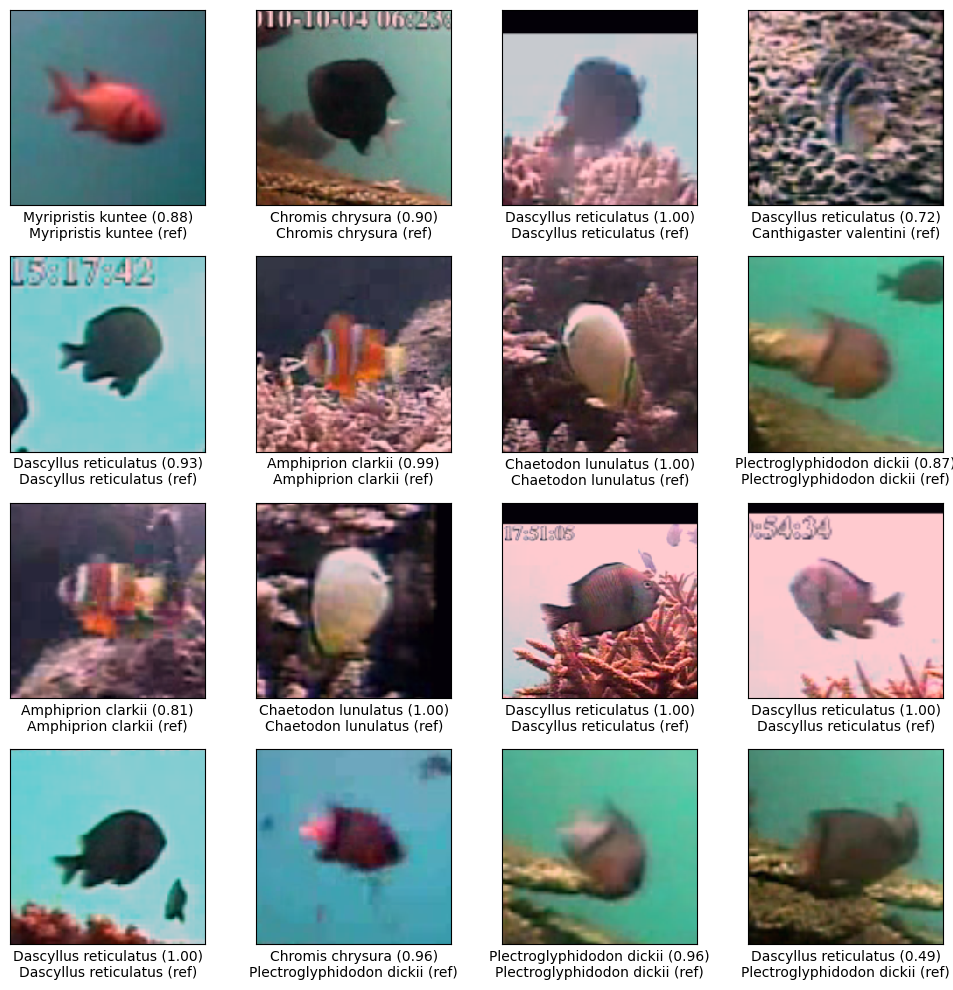

In [ ]:
def viz_image_batch(images, model, classes, top=5, device='cpu', labels=None):
    ## BEGIN SOLUTION
    assert images.ndim == 4, "Images are expected to have 4 dimensions: batch index x channels x height x width"
    model.to(device)

    was_training = model.training
    model.eval()

    with torch.no_grad():
        logits = model(images.to(device))

        probs = torch.softmax(logits, dim=1)

        max_prob, max_class = torch.max(probs, dim=1)

        n_images = images.shape[0]
        n_cols = int(np.ceil(np.sqrt(n_images)))
        n_rows = int(np.ceil(n_images / n_cols))

        fig = plt.figure(figsize=(10, 10))
        for i, image in enumerate(images):
            ax = fig.add_subplot(n_rows, n_cols, i+1)

            # Normalize the image
            image_n = (image - image.min()) / (image.max() - image.min())

            ax.imshow(image_n.permute(1,2,0), interpolation='nearest')
            ax.set_xticks([])
            ax.set_yticks([])
            if labels is not None:
                ax.set_xlabel(f'{classes[max_class[i]]} ({max_prob[i]:.2f})\n{classes[labels[i]]} (ref)')
            else:
                ax.set_xlabel(f'{classes[max_class[i]]} ({max_prob[i]:.2f})')

    plt.tight_layout()
    model.train(was_training)

    ## END SOLUTION
    return probs, max_class


test_loader = torch.utils.data.DataLoader(test_set, batch_size=16, pin_memory=True, num_workers=2)

images, labels = next(iter(test_loader))
viz_image_batch(images, model, full_set.classes, labels=labels, device=device)

# ResNet model

ResNets are a family of models that have been popularized by their performance in image classification tasks. We will start by downloading a [ResNet18 model](https://pytorch.org/vision/stable/models.html#torchvision.models.resnet18) (a ResNet model composed of 18 layers). Other variants exist with varying number of layers: `resnet34`, `resnet50`, `resnet101`, `resnet152`.

When using an existing model with our particular task, we must first ensure that the inputs of the model are correctly matched.
- The images must have a size compatible with the model

In the case of resnet18, it expects images of size 224x224. In Exercise 11 we had created our datasets for the underwater images in a way that images were scaled (and cropped when necessary) to this size.

```
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    ...
    ]
```
- The images must have been normalised in an equal (or similar) way

In [torchvision documentation](https://pytorch.org/vision/stable/models.html#:~:text=All%20pre%2Dtrained,0.229%2C%200.224%2C%200.225%5D)) we find that the models expect images to be normalized with zero mean and standard deviation of 1.  For the natural images in ImageNet, this corresponds to the following transform:

```
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ]
```

However in this lab we have recomputed the statistics of a subsample of our data, since underwater images may have significantly different statistics.

- The output of the model may need to be modified to match our class set

At first we will not change the output, however the following exercises will require changing the final layer of the model to adapt to our own class set.


## Exercise 17
We will start by downloading a pre-trained `resnet18` and visualizing how it classifies our own images into the ImageNet classes.
**Note**: in order to show the class labels with which it was trained, we could download ImageNet using [`torchvision.datasets.ImageNet`](https://pytorch.org/vision/stable/datasets.html#imagenet) and access the `.classes` attribute of the dataset. However this would take a long unnecessary time and bandwidth, since only the labels are needed. PyTorch is currently revisiting the API of pretrained models ([see here](https://github.com/pytorch/vision/pull/4610)) to solve this and other issues. In the meantime we can download the class list from [https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt](https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt).  

In [ ]:
### BEGIN SOLUTION
# Download the file using wget
!wget -nc https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
### END SOLUTION

--2023-11-25 20:04:52--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2023-11-25 20:04:52 (125 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



In [ ]:
### BEGIN SOLUTION
# Read the categories from the file
with open("imagenet_classes.txt", "r") as f:
  imagenet_classes = [s.strip() for s in f.readlines()]


### END SOLUTION

print(len(imagenet_classes))

1000


Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 94.5MB/s]


(tensor([[1.6936e-04, 5.0262e-01, 2.2331e-03,  ..., 7.6551e-05, 2.9445e-05,
          1.6415e-05],
         [1.2139e-05, 1.7921e-04, 2.1213e-03,  ..., 4.8157e-04, 1.1808e-04,
          1.3834e-03],
         [8.4823e-05, 3.3433e-05, 2.2977e-05,  ..., 8.0449e-06, 1.4043e-04,
          1.0747e-05],
         ...,
         [9.7474e-05, 7.5352e-03, 3.4757e-03,  ..., 1.4100e-04, 5.8377e-05,
          4.0592e-06],
         [5.7462e-04, 1.8564e-03, 4.3642e-03,  ..., 1.6760e-04, 5.2128e-05,
          3.4371e-06],
         [2.2802e-04, 4.5009e-05, 2.8357e-04,  ..., 7.3404e-04, 1.6753e-04,
          2.6251e-06]], device='cuda:0'),
 tensor([  1, 921, 812, 350, 392, 120, 347, 149, 980, 577, 973,  80,   5, 107,
         149, 360], device='cuda:0'))

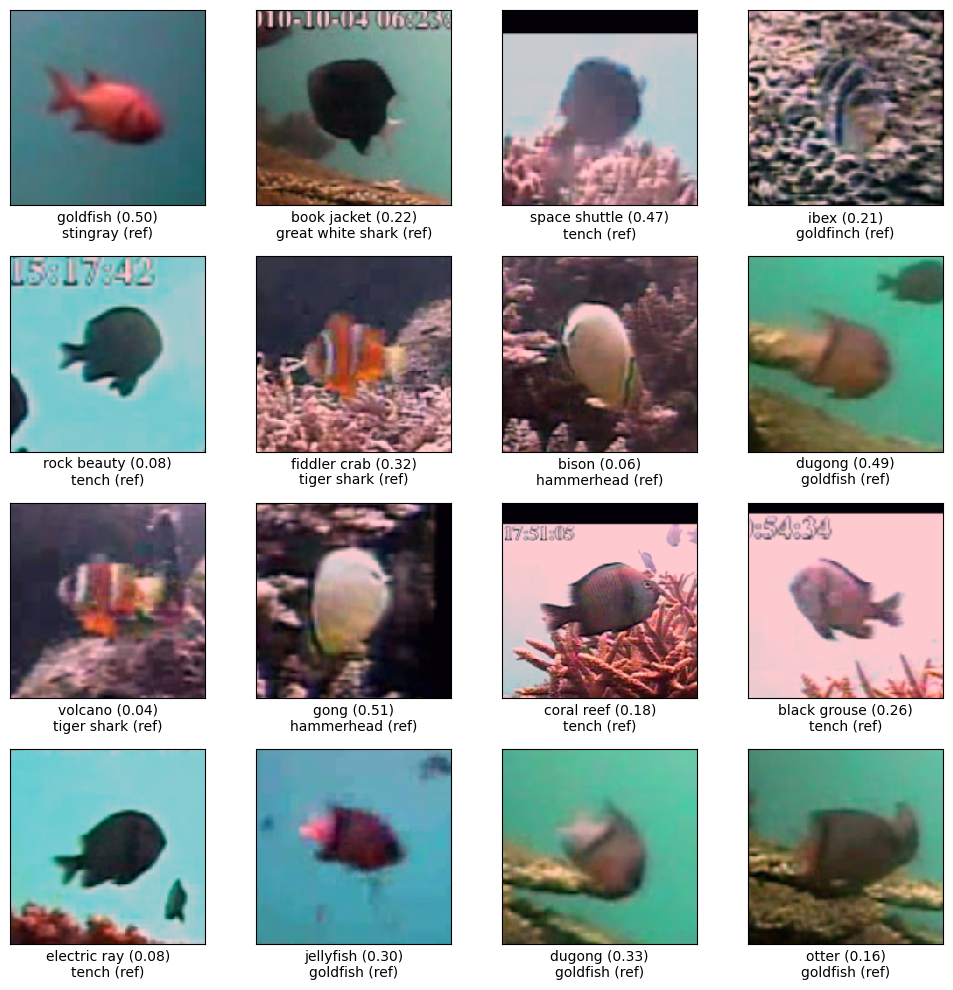

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

### BEGIN SOLUTION

test_loader = torch.utils.data.DataLoader(test_set, batch_size=16, pin_memory =True, num_workers =2)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=16, pin_memory=True, num_workers=2)

images, labels = next(iter(test_loader))
viz_image_batch(images, model, imagenet_classes, labels=labels, device=device)
### END SOLUTION

## Exercise 18

Comment on the results.


the results is poor  due to the model is using an archeticture that is not optimezed for this dataset, so the model did not learn any properties or characeteriscs of these classes that make up this dataset.

We are now going to explore different settings of reusing the resnet-18 model. We will start with a non-pretrained model, by initialising the weights randomly and training all layers using the standard training loop that we did before.

To achieve this our first step is to **replace the output layer** in order to output logits for the correct number of classes (those found in our data).

We will first print the resnet model and identify the last layer.

## Exercise 19

Print a non-pretrained resnet18 model and identify the name of the output layer.

In [ ]:
### BEGIN SOLUTION
print(model)

### END SOLUTION

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

`fc` stands for Fully Connected, and it is the last layer in the model.

In order to replace it we must first remember it's input dimensionality, which can be obtained using `fc.in_features`.

## Exercise 20

Replace the `fc` layer of the vanilla resnet-18 by another `Linear` layer with as many outputs as classes in our fish dataset.

In [ ]:
### BEGIN SOLUTION
# Load the model
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)

# Replace the last layer
model.fc = nn.Linear(in_features =512, out_features=len(full_set.classes), bias =True)



### END SOLUTION

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, pin_memory=True, num_workers=2)

train_model(model, train_loader, optimizer, criterion, n_epochs=2, device=device, log_every=50)
accuracy = evaluate_model(model, test_loader, device=device)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


episode:   0, iter:    0, Loss: 0.055
episode:   0, iter:   50, Loss: 0.027
episode:   0, iter:  100, Loss: 0.018
episode:   0, iter:  150, Loss: 0.014
episode:   0, iter:  200, Loss: 0.013
episode:   0, iter:  250, Loss: 0.011
episode:   0, iter:  300, Loss: 0.010
episode:   1, iter:    0, Loss: 0.009
episode:   1, iter:   50, Loss: 0.009
episode:   1, iter:  100, Loss: 0.008
episode:   1, iter:  150, Loss: 0.008
episode:   1, iter:  200, Loss: 0.008
episode:   1, iter:  250, Loss: 0.007
episode:   1, iter:  300, Loss: 0.007
Accuracy of the network on the test images: 88.9%


## Exercise 21

We will now try to leverage the large amount of natural imaging data from ImageNet, by using as backbone a pretrained resnet18 as starting point for training.


In [ ]:
### BEGIN SOLUTION
# Load the model
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

# Replace the last layer
model.fc = nn.Linear(in_features =512, out_features=len(full_set.classes), bias =True)



### END SOLUTION

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, pin_memory=True, num_workers=2)

train_model(model, train_loader, optimizer, criterion, n_epochs=2, device=device, log_every=50)
accuracy = evaluate_model(model, test_loader, device=device)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')



Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


episode:   0, iter:    0, Loss: 0.049
episode:   0, iter:   50, Loss: 0.020
episode:   0, iter:  100, Loss: 0.008
episode:   0, iter:  150, Loss: 0.006
episode:   0, iter:  200, Loss: 0.005
episode:   0, iter:  250, Loss: 0.004
episode:   0, iter:  300, Loss: 0.003
episode:   1, iter:    0, Loss: 0.003
episode:   1, iter:   50, Loss: 0.003
episode:   1, iter:  100, Loss: 0.002
episode:   1, iter:  150, Loss: 0.002
episode:   1, iter:  200, Loss: 0.002
episode:   1, iter:  250, Loss: 0.002
episode:   1, iter:  300, Loss: 0.001
Accuracy of the network on the test images: 97.9%


## Exercise 22
In some situations it may be faster and better in terms of acheived accuracy, to only train the last layer, while letting all other layers with their pretrained weights. To freeze a layer you may simply set the `require_grad` attribute of its parameters to `False`.

Sometimes it is still beneficial to perform an additional training phase in which all weights are updated for a couple of epochs. This is known as **fine tuning**. In this exercise we will only be training the inserted layer.

Implement this method and visualize the results on the first batch of test.

**Note**: You may iterate over all parameters of a model calling its `.parameters()` method.

**Note**: Make sure to not freeze the latest layer that you added.


In [ ]:
### BEGIN SOLUTION
# Load the model
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

# Replace the last layer
model.fc = nn.Linear(in_features =512, out_features=len(full_set.classes), bias =True)

# set the model parameters to not require gradient computation
for param in model.parameters():
  param.requires_grad = False

last_layer_param  =list(model.fc.parameters())
# setting the last layer parameters to copute gradient.
for param in last_layer_param:
  param.requires_grad = True
### END SOLUTION

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, pin_memory=True, num_workers=2)

train_model(model, train_loader, optimizer, criterion, n_epochs=2, device=device, log_every=50)
accuracy = evaluate_model(model, test_loader, device=device)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


episode:   0, iter:    0, Loss: 0.053
episode:   0, iter:   50, Loss: 0.026
episode:   0, iter:  100, Loss: 0.016
episode:   0, iter:  150, Loss: 0.012
episode:   0, iter:  200, Loss: 0.012
episode:   0, iter:  250, Loss: 0.011
episode:   0, iter:  300, Loss: 0.010
episode:   1, iter:    0, Loss: 0.007
episode:   1, iter:   50, Loss: 0.009
episode:   1, iter:  100, Loss: 0.009
episode:   1, iter:  150, Loss: 0.008
episode:   1, iter:  200, Loss: 0.008
episode:   1, iter:  250, Loss: 0.008
episode:   1, iter:  300, Loss: 0.008
Accuracy of the network on the test images: 88.8%


## Exercise 23

Visualize the first batch of 16 images and it's predicted class in test.

(tensor([[2.8627e-02, 5.6177e-01, 2.5417e-03, 1.5996e-02, 1.0983e-03, 2.8714e-03,
          3.4366e-01, 6.8897e-03, 2.1536e-03, 2.2366e-03, 3.3027e-03, 2.3209e-03,
          4.5594e-03, 4.2333e-03, 1.3180e-03, 3.4128e-03, 1.6928e-03, 3.2679e-03,
          1.0960e-03, 2.2461e-03, 8.3352e-04, 2.9852e-03, 8.8929e-04],
         [3.4330e-02, 3.5372e-02, 9.1549e-01, 2.4685e-04, 1.8045e-03, 6.2813e-04,
          6.3660e-04, 2.1338e-03, 1.8647e-03, 1.1408e-03, 1.2404e-03, 9.4956e-04,
          4.9632e-04, 8.8493e-04, 1.6367e-04, 1.2429e-03, 2.0924e-04, 4.9884e-04,
          1.6517e-04, 4.9525e-05, 1.0537e-04, 2.6782e-04, 8.1320e-05],
         [9.3631e-01, 7.7577e-04, 3.1711e-03, 2.8491e-02, 3.7042e-03, 6.2561e-03,
          3.3306e-04, 6.4325e-04, 2.3989e-03, 3.4418e-04, 1.9491e-03, 2.8113e-03,
          9.1554e-03, 2.6490e-04, 5.2048e-04, 8.8250e-04, 3.0948e-04, 2.5026e-04,
          2.5739e-04, 2.4398e-04, 7.8993e-05, 7.4991e-04, 1.0258e-04],
         [1.3340e-01, 6.5923e-02, 9.8950e-03, 1.6

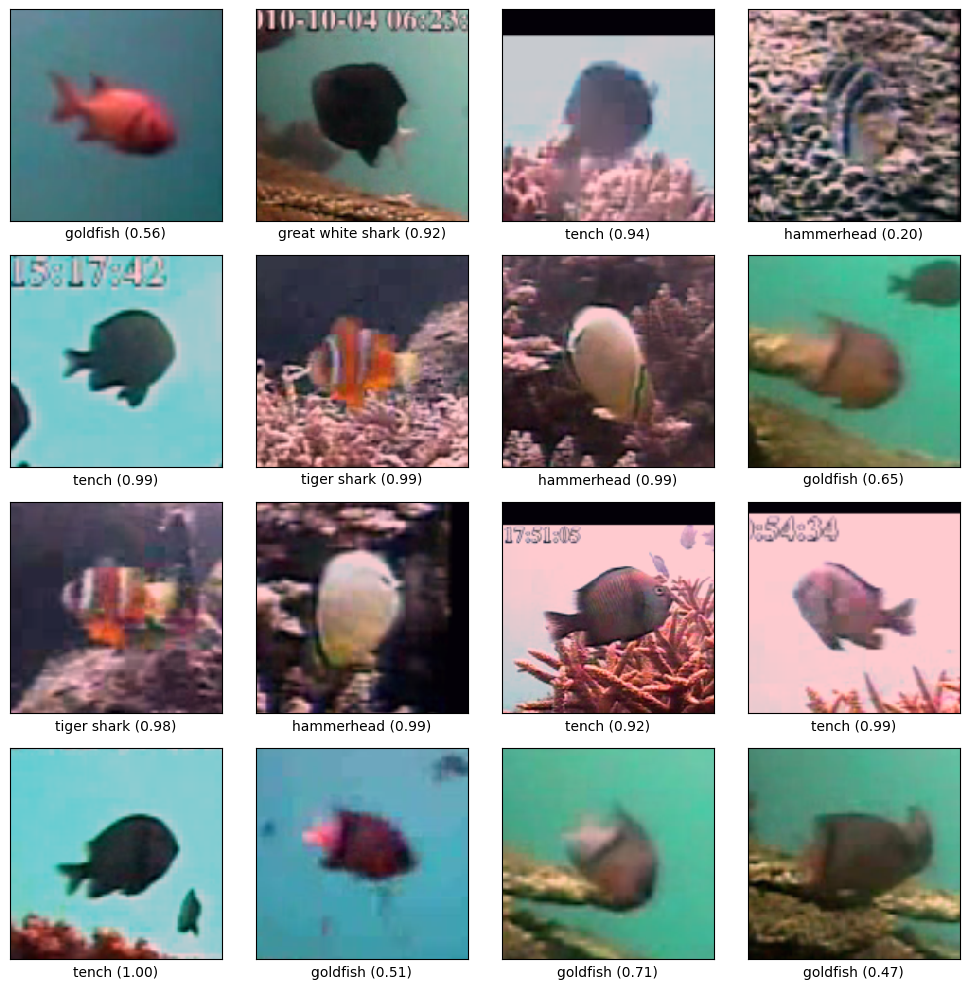

In [ ]:
### BEGIN SOLUTION
# creating test data with batch size  = 16
test_loader  =torch.utils.data.DataLoader(test_set, batch_size=16, pin_memory=True, num_workers=2)

# taking the first batch
images,labels = next(iter(test_loader))
# visualizing the first 16 images
viz_image_batch(images,model, imagenet_classes, device = device)
### END SOLUTION

## [Advanced] Exercise 24

Try with one (or all) of the following backbones: [`AlexNet`](https://pytorch.org/hub/pytorch_vision_alexnet/), [`VGG`](https://pytorch.org/hub/pytorch_vision_vgg/), [`MobileNetV2`](https://pytorch.org/hub/pytorch_vision_mobilenet_v2/)

### VGG

In [ ]:
# Download the pretrained VGG
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg11', pretrained =True)
print(model)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:08<00:00, 64.4MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [ ]:
# make changes in the last linear layer from vgg19

# changes the ouput of the last linear layer from VGG19
model.classifier[6].out_features = len(full_set.classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, pin_memory=True, num_workers=2)

train_model(model, train_loader, optimizer, criterion, n_epochs=2, device=device, log_every=50)
accuracy = evaluate_model(model, test_loader, device=device)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')

episode:   0, iter:    0, Loss: 0.136
episode:   0, iter:   50, Loss: 0.026
episode:   0, iter:  100, Loss: 0.009
episode:   0, iter:  150, Loss: 0.006
episode:   0, iter:  200, Loss: 0.005
episode:   0, iter:  250, Loss: 0.004
episode:   0, iter:  300, Loss: 0.003
episode:   1, iter:    0, Loss: 0.002
episode:   1, iter:   50, Loss: 0.002
episode:   1, iter:  100, Loss: 0.002
episode:   1, iter:  150, Loss: 0.002
episode:   1, iter:  200, Loss: 0.001
episode:   1, iter:  250, Loss: 0.001
episode:   1, iter:  300, Loss: 0.001
Accuracy of the network on the test images: 98.3%


### MobilNET V2

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained =True)
print(model)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 94.8MB/s]

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
# make changes in the last linear layer from MobilNet
model.classifier[1].out_features = len(full_set.classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, pin_memory=True, num_workers=2)

train_model(model, train_loader, optimizer, criterion, n_epochs=2, device=device, log_every=50)
accuracy = evaluate_model(model, test_loader, device=device)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')

episode:   0, iter:    0, Loss: 0.174
episode:   0, iter:   50, Loss: 0.034
episode:   0, iter:  100, Loss: 0.005
episode:   0, iter:  150, Loss: 0.003
episode:   0, iter:  200, Loss: 0.002
episode:   0, iter:  250, Loss: 0.002
episode:   0, iter:  300, Loss: 0.001
episode:   1, iter:    0, Loss: 0.001
episode:   1, iter:   50, Loss: 0.001
episode:   1, iter:  100, Loss: 0.001
episode:   1, iter:  150, Loss: 0.000
episode:   1, iter:  200, Loss: 0.000
episode:   1, iter:  250, Loss: 0.000
episode:   1, iter:  300, Loss: 0.000
Accuracy of the network on the test images: 98.9%


### AlexNET


In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained =True)
print(model)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 152MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
# make changes in the last linear layer from alexnet
model. classifier[6].out_features = len(full_set.classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, pin_memory=True, num_workers=2)

train_model(model, train_loader, optimizer, criterion, n_epochs=2, device=device, log_every=50)
accuracy = evaluate_model(model, test_loader, device=device)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')

episode:   0, iter:    0, Loss: 0.142
episode:   0, iter:   50, Loss: 0.024
episode:   0, iter:  100, Loss: 0.008
episode:   0, iter:  150, Loss: 0.006
episode:   0, iter:  200, Loss: 0.005
episode:   0, iter:  250, Loss: 0.004
episode:   0, iter:  300, Loss: 0.004
episode:   1, iter:    0, Loss: 0.002
episode:   1, iter:   50, Loss: 0.002
episode:   1, iter:  100, Loss: 0.002
episode:   1, iter:  150, Loss: 0.002
episode:   1, iter:  200, Loss: 0.002
episode:   1, iter:  250, Loss: 0.001
episode:   1, iter:  300, Loss: 0.001
Accuracy of the network on the test images: 97.8%


## [Advanced] Exercise 25

Perform fine tuning on one (or all) of the previous backbones.

I will perform Fine Tunning on AlexNET

In [ ]:
### BEGIN SOLUTION
model.classifier[1].out_features = len(full_set.classes)

# set the model parameters to not require gradient computation
for param in model.parameters():
  param.requires_grad = False

last_layer_param = list(model.classifier[1].parameters())
# setting the last layer parameters to copute gradient.
for param in last_layer_param:
  param.requires_grad = True
### END SOLUTION

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, pin_memory=True, num_workers=2)

train_model(model, train_loader, optimizer, criterion, n_epochs=2, device=device, log_every=50)
accuracy = evaluate_model(model, test_loader, device=device)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')

episode:   0, iter:    0, Loss: 0.001
episode:   0, iter:   50, Loss: 0.001
episode:   0, iter:  100, Loss: 0.001
episode:   0, iter:  150, Loss: 0.001
episode:   0, iter:  200, Loss: 0.001
episode:   0, iter:  250, Loss: 0.001
episode:   0, iter:  300, Loss: 0.001
episode:   1, iter:    0, Loss: 0.001
episode:   1, iter:   50, Loss: 0.001
episode:   1, iter:  100, Loss: 0.001
episode:   1, iter:  150, Loss: 0.001
episode:   1, iter:  200, Loss: 0.001
episode:   1, iter:  250, Loss: 0.001
episode:   1, iter:  300, Loss: 0.001
Accuracy of the network on the test images: 98.2%


(tensor([[6.5643e-06, 5.4697e-02, 1.2026e-07,  ..., 4.8425e-10, 9.2342e-10,
          1.2342e-10],
         [6.0405e-08, 1.3399e-11, 1.0000e+00,  ..., 9.8639e-15, 2.2232e-15,
          1.2157e-13],
         [9.9929e-01, 2.1551e-06, 4.4503e-04,  ..., 1.2695e-09, 7.4729e-11,
          9.4344e-11],
         ...,
         [8.9502e-07, 9.9996e-01, 1.7751e-07,  ..., 2.8922e-11, 2.3600e-11,
          7.2703e-12],
         [2.3031e-04, 9.9456e-01, 2.4648e-03,  ..., 2.4849e-08, 2.0509e-08,
          5.6879e-09],
         [1.2564e-04, 9.9979e-01, 7.2855e-06,  ..., 9.9631e-11, 2.1472e-11,
          4.9576e-12]], device='cuda:0'),
 tensor([ 6,  2,  0, 11,  0,  3,  4,  1,  3,  4,  0,  0,  0,  1,  1,  1],
        device='cuda:0'))

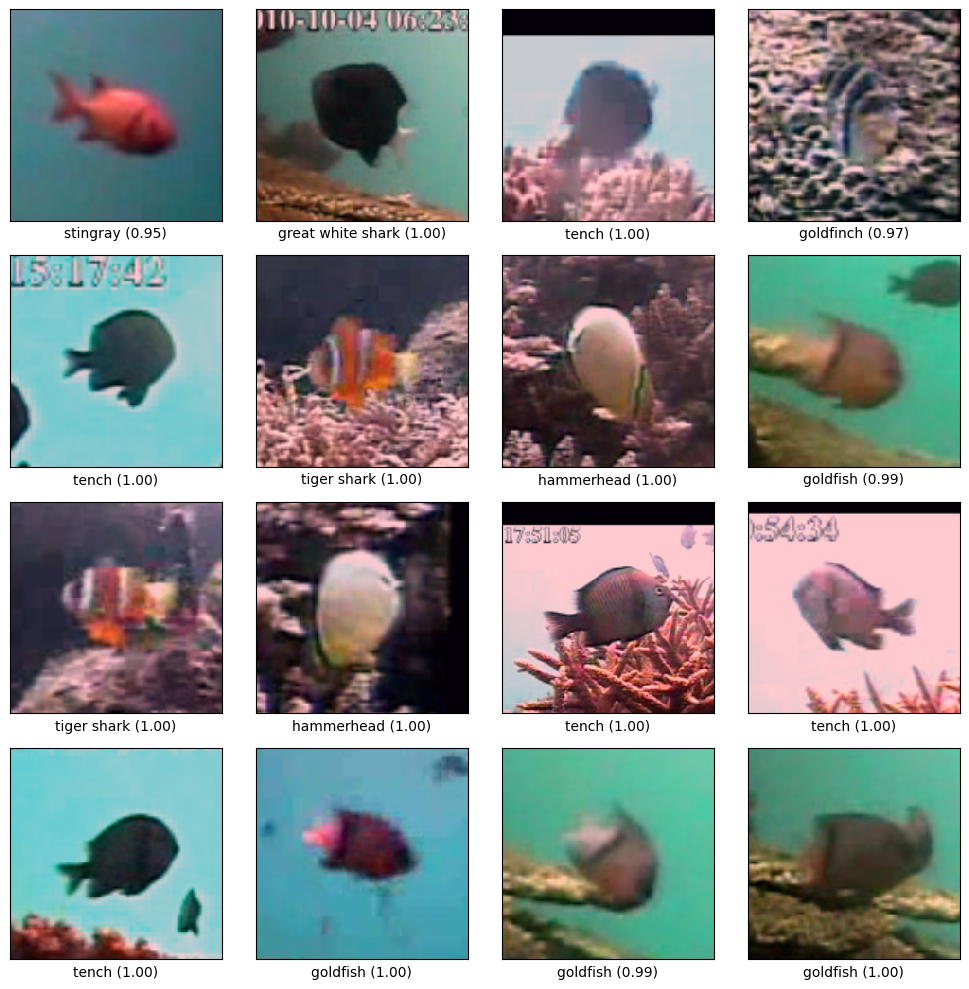

In [ ]:
### BEGIN SOLUTION
# creating test data with batch size  = 16
test_loader  =torch.utils.data.DataLoader(test_set, batch_size=16, pin_memory=True, num_workers=2)

# taking the first batch
images,labels = next(iter(test_loader))
# visualizing the first 16 images
viz_image_batch(images,model, imagenet_classes, device = device)
### END SOLUTION